In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)

In [17]:
os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_training/')
from ensemble_train import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_explanation/')
from ensemble_explanation import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_evaluation/')
from ensemble_evaluation import compare_ensembles_rocs_on_dataset,calculate_rocs_on_datasets,calculate_metrics_on_datasets,calculate_experiment_performance_on_datasets
from base_evaluation import * 

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preprocessing')
from ensemble_preprocessing import execute_ensemble_preprocessing

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preparation')
from ensemble_preparation import execute_ensemble_preparation

In [3]:
def prepare_patient_data_for_explanations(df_test,ebm,cutoff,axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26'):

    predicted_probas = ebm.predict_proba(df_test.drop(label,axis=1))[:,-1]

    df_essential_data = df_test[[axial_label,coronal_label,sagittal_label,'DIAGNOSIS']]
    df_essential_data.loc[:,'FINAL_PREDICTED_SCORE'] = np.round(predicted_probas * 100000) / 100000
    df_essential_data.loc[:,'FINAL_PREDICTION'] = [1  if x>=cutoff else 0 for x in predicted_probas]


    df_patient_data = pd.read_csv('/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv')
    imageid = df_patient_data['IMAGEUID']
    df_patient_data['IMAGE_DATA_ID'] = ['I'+str(x) for x in imageid]
    df_patient_data.set_index("IMAGE_DATA_ID",inplace=True)
    df_patient_data = df_patient_data[['AGE','MALE','YEARS_EDUCATION','HISPANIC', 'RACE','WIDOWED']]

    df_patient_data.rename(columns={'MALE':'GENDER'},inplace=True)
    df_patient_data['RACE'] = df_patient_data['RACE'].str.upper()

    df_patient_data.loc[df_patient_data['HISPANIC'] == 1,'HISPANIC'] = 'YES'
    df_patient_data.loc[df_patient_data['HISPANIC'] == 0,'HISPANIC'] = 'NO'

    df_patient_data.loc[df_patient_data['WIDOWED'] == 1,'WIDOWED'] = 'YES'
    df_patient_data.loc[df_patient_data['WIDOWED'] == 0,'WIDOWED'] = 'NO'

    df_patient_data.loc[df_patient_data['GENDER'] == 1,'GENDER'] = 'MALE'
    df_patient_data.loc[df_patient_data['GENDER'] == 0,'GENDER'] = 'FEMALE'

    df_patient_data = df_patient_data.merge(df_essential_data,right_index=True,left_index=True)

    df_patient_data.loc[df_patient_data['DIAGNOSIS'] == 1,'DIAGNOSIS'] = 'AD'
    df_patient_data.loc[df_patient_data['DIAGNOSIS'] == 0,'DIAGNOSIS'] = 'CN'

    df_patient_data.loc[df_patient_data['FINAL_PREDICTION'] == 1,'FINAL_PREDICTION'] = 'AD'
    df_patient_data.loc[df_patient_data['FINAL_PREDICTION'] == 0,'FINAL_PREDICTION'] = 'CN'

    df_patient_data[axial_label] = [np.round(x*100000)/100000 for x in df_patient_data[axial_label]]
    df_patient_data[coronal_label] = [np.round(x*100000)/100000 for x in df_patient_data[coronal_label]]
    df_patient_data[sagittal_label] = [np.round(x*100000)/100000 for x in df_patient_data[sagittal_label]]
    return df_patient_data

def plot_local_explanation(ebm,df,df_patient_data,sample_id = 'I335435',title = '',
                            normalized=True,figsize=(9,4),top_features=None):
    
    label='DIAGNOSIS'
    df_query = df.query("index == @sample_id")
    local_explanation = ebm.explain_local(df_query.drop(label,axis=1),df_query[label])._internal_obj['specific'][0]
    feature_names = local_explanation['names']
    feature_importances = local_explanation['scores']
    # feature_values = local_explanation['values']
    # feature_names_with_values = [ name + ' (' + str(value) + ')' for name,value in zip(feature_names,feature_values)]
    df_weights_ebm = create_normalized_by_feature_weight(feature_names,feature_importances);
    df_weights_ebm = df_weights_ebm.sort_values(by=['abs_Weights'],ascending = True,inplace = False)
    
    if normalized:
        column = 'normalized'
    else:
        column = 'Weights'
        
    if top_features is not None:
        df_weights_ebm = df_weights_ebm.iloc[-top_features:]

    fig,ax = plt.subplots(1,figsize=figsize)
    color = ('r','g')
    colors = (0.2,0.4,0.8)

    if color is not None:
        color_mask = df_weights_ebm['normalized'] > 0
        colors = [color[0] if c else color[1] for c in color_mask]
        legend_elements = [
            Patch(facecolor = color[1], edgecolor='k', label='Negative Contribution'),
            Patch(facecolor = color[0], edgecolor='k', label='Positive Contribution')]

    ax.tick_params(axis = 'both',labelsize = 'large')
    df_weights_ebm[column].plot(kind = 'barh', grid = True,color = colors, edgecolor='k', alpha = 0.6,ax = ax)

    plt.grid(True)
    fig.suptitle('Local Explanations - '+title,fontsize = 20,x=0.45)

    if color:
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, -0.05), borderaxespad=0.,fancybox=True, shadow=True,ncol = 2)

    plt.subplots_adjust(top=0.9, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.85)

    features = df_patient_data.query("index == @sample_id").iloc[0].to_dict()
    age,gender,years_education = features['AGE'],features['GENDER'],features['YEARS_EDUCATION']
    hispanic,race,widowed = features['HISPANIC'],features['RACE'],features['WIDOWED']
    true_diagnosis,predicted_score,predicted_diagnosis = features['DIAGNOSIS'],features['FINAL_PREDICTED_SCORE'],features['FINAL_PREDICTION']
    axial,coronal,sagittal = features['AXIAL_23'],features['CORONAL_43'],features['SAGITTAL_26']
    plt.figtext(-0.2, -0.2, f'Is Hispanic:{hispanic}    Race:{race}   Is Widowed:{widowed}   Age:{age}    Gender:{gender}   Years of Education:{years_education}', horizontalalignment='left',fontdict={'size':16})
    plt.figtext(-0.2, -0.3, f'AXIAL_23 score:{axial}    CORONAL_43 score:{coronal}   SAGITTAL_26 score:{sagittal}', horizontalalignment='left',fontdict={'size':16})
    plt.figtext(-0.2, -0.4, f'Predicted Diagnosis: {predicted_diagnosis}   Ensemble Predicted score: {predicted_score}', horizontalalignment='left',fontdict={'size':16,'weight':'heavy'})
    plt.figtext(-0.2, -0.5, f'True Diagnosis:{true_diagnosis}', horizontalalignment='left',fontdict={'size':16,'weight':'heavy'})

    return fig

# Ensemble of CNNs + Demographics

## AD x CN

In [4]:
# mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_VGG19_BN_1125.csv'
# cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS_1125.csv'

mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_23', 'CORONAL_43','SAGITTAL_26', 'COGTEST', 'DIAGNOSIS']

In [5]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm = ExplainableBoostingClassifier()
models = train_ensemble_models(df_train,label,[ebm])

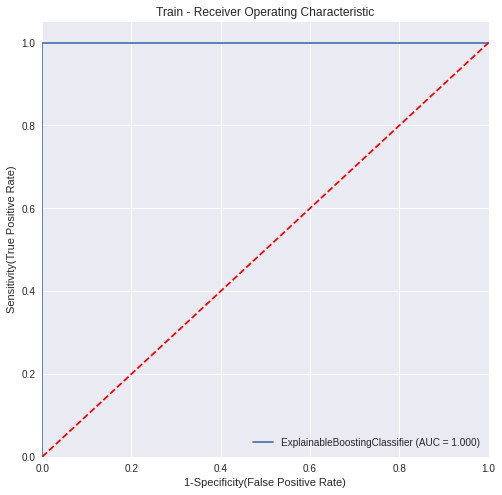

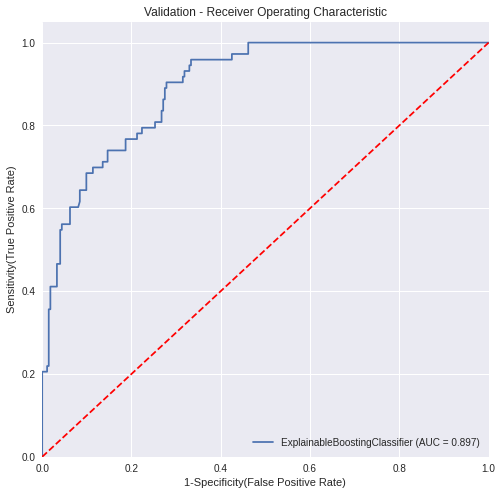

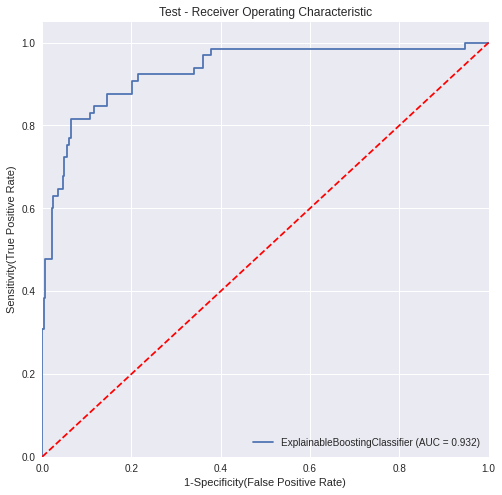


ExplainableBoostingClassifier Results for Train:
Optimal Threshold: 1.0000
----------------
Total samples in batch: (709,)
AUC:       1.000
Accuracy:  1.000
F1:        1.000
Precision: 1.000
Recall:    1.000
Confusion Matrix: 
 [[554   0]
 [  0 155]]
----------------

---------------------------------------
ExplainableBoostingClassifier Results for Validation:
Optimal Threshold: 0.0000
----------------
Total samples in batch: (346,)
AUC:       0.897
Accuracy:  0.760
F1:        0.614
Precision: 0.465
Recall:    0.904
Confusion Matrix: 
 [[197  76]
 [  7  66]]
----------------

---------------------------------------
ExplainableBoostingClassifier Results for Test:
Optimal Threshold: 0.0000
----------------
Total samples in batch: (348,)
AUC:       0.932
Accuracy:  0.799
F1:        0.632
Precision: 0.480
Recall:    0.923
Confusion Matrix: 
 [[218  65]
 [  5  60]]
----------------

---------------------------------------


In [6]:
df_rocs = calculate_experiment_performance_on_datasets(models,datasets,label);

In [9]:
# sns.histplot(df,x='FINAL_PREDICTED_SCORE',binwidth=0.05)
# plt.show()

In [20]:
cutoff = df_rocs['Optimal_Thresh'].iloc[-1]

y_true = df_test[label]
y_pred = ebm.predict(df_test.drop(label,axis=1))
y_pred_proba = ebm.predict_proba(df_test.drop(label,axis=1))[:,-1]
y_pred_custom = np.array([1 if x >= cutoff else 0 for x in y_pred_proba])

print("Using 0.5 cutoff:")
compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = 0.5,verbose=1)
print('')
print(f"Using {cutoff} cutoff:")

compute_metrics_binary(y_true, y_pred_proba = y_pred_proba,threshold = cutoff,verbose=1)

Using 0.5 cutoff:
----------------
Total samples in batch: (348,)
AUC:       0.932
Accuracy:  0.888
F1:        0.621
Precision: 0.842
Recall:    0.492
Confusion Matrix: 
 [[277   6]
 [ 33  32]]
----------------

Using 5.105240851666442e-06 cutoff:
----------------
Total samples in batch: (348,)
AUC:       0.932
Accuracy:  0.799
F1:        0.632
Precision: 0.480
Recall:    0.923
Confusion Matrix: 
 [[218  65]
 [  5  60]]
----------------


{'auc': 0.9317749388420767,
 'accuracy': 0.7988505747126436,
 'f1score': 0.631578947368421,
 'precision': 0.48,
 'recall': 0.9230769230769231,
 'conf_mat': array([[218,  65],
        [  5,  60]])}

In [27]:
df_patient_data = prepare_patient_data_for_explanations(df_validation,ebm,cutoff,axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26')
# df_patient_data.query("FINAL_PREDICTED_SCORE < 0.8 and FINAL_PREDICTED_SCORE > 0.1").head()

/home/lucas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [33]:
from scipy.stats import mannwhitneyu

false_positives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'CN'")['FINAL_PREDICTED_SCORE']
true_positives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'AD'")['FINAL_PREDICTED_SCORE']

stats,pvalue = mannwhitneyu(true_positives,false_positives)
print("p-value:",pvalue)
print("The predicted scores distribution is different between true negative and true positives because p-value < 0.05")


p-value: 5.712495178793149e-07
The predicted scores distribution is different between true negative and true positives because p-value < 0.05


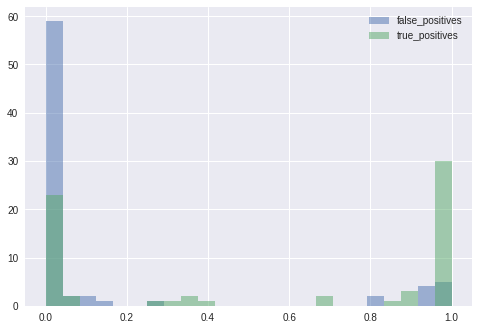

In [42]:
false_positives.mean(),false_positives.std()

bins = np.linspace(0, 1, 25)
plt.hist(false_positives, bins, alpha=0.5, label='false_positives')
plt.hist(true_positives, bins, alpha=0.5, label='true_positives')
plt.legend(loc='upper right')
plt.show()

/home/lucas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


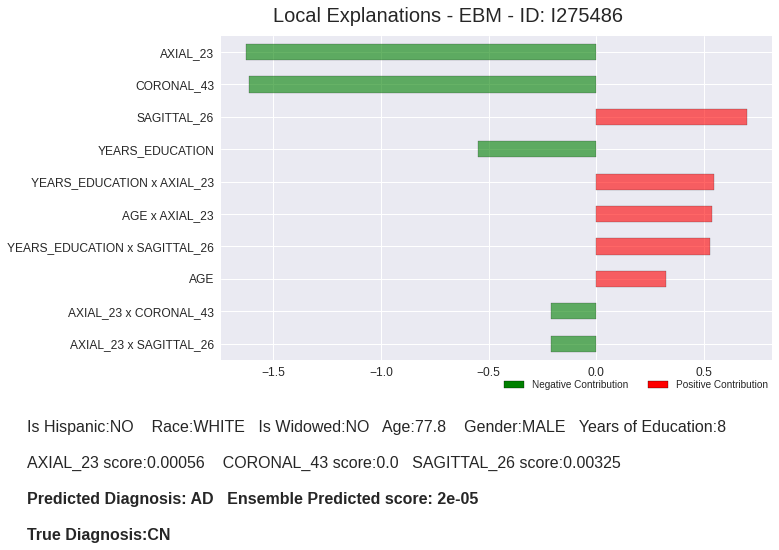

In [44]:
df_patient_data = prepare_patient_data_for_explanations(df_test,ebm,cutoff,axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26')
sample_id = 'I275486'
fig= plot_local_explanation(ebm,df_test,df_patient_data,sample_id = sample_id,title = f'EBM - ID: {sample_id}',
                            normalized=False,figsize=(9,5),top_features=10)

In [90]:
# show(ebm.explain_local(df_query.drop(label,axis=1),df_query[label]),name='Local Explanation for Ensemble of CNNs+Demographics')

<!-- http://127.0.0.1:7001/140212464219760/ -->